In [1]:
#Import libraries 
import tensorflow as tf
import numpy as np 
import keras
import pandas as pd 
import cv2 as cv
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
#load data 
data = np.load("dataset.npy", allow_pickle=True)
print("Shape of Data is: ",data.shape)#shape of data

Shape of Data is:  (11446, 2)


##### 11446 x 2 represents a 11446 x 2 matrix with first entry as images and second as the class label of it. While creating the dataset we transformed our images from size 512 x 512 x 3 to 228 x 228 x 3, 3 is the number of channels in the image since it is a RGB image.

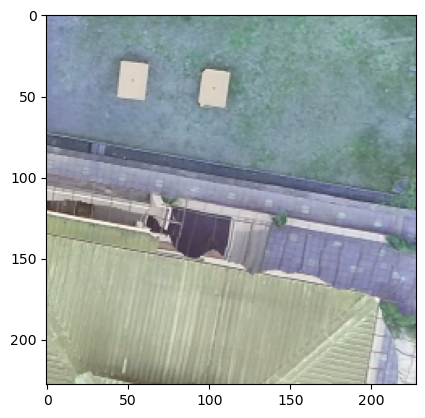

In [6]:
img1= data[0][0]# first image 
plt.imshow(img1)

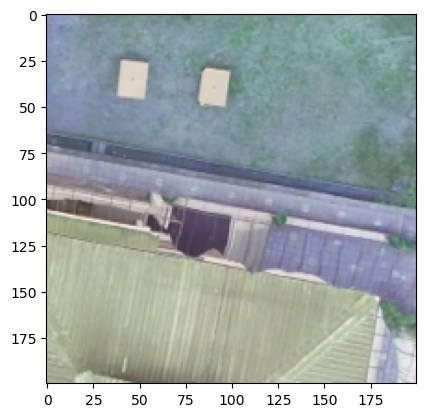

In [9]:
from PIL import Image
image = Image.fromarray(img1)
img = image.resize((200, 200), Image.BILINEAR) 
plt.imshow(img)

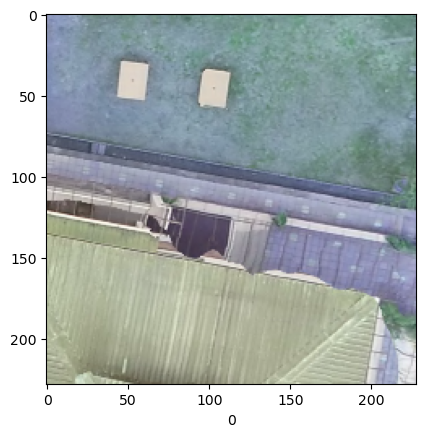

In [3]:
#displaying one image 
label=data[0][1]#first image label 
img1= data[0][0]# first image 
plt.imshow(img1)
plt.xlabel(f"{label}")
plt.show()

In [4]:
#creating features and target variables 
X=[]#features 
Y=[]#target
for x in range(data.shape[0]):
    if data[x][1]==1 or data[x][1]==2 or data[x][1]==3:
        X.append(data[x][0])
        Y.append(data[x][1])
print(f"Number of elements in X are {len(X)} and in Y are {len(Y)}")

Number of elements in X are 1489 and in Y are 1489


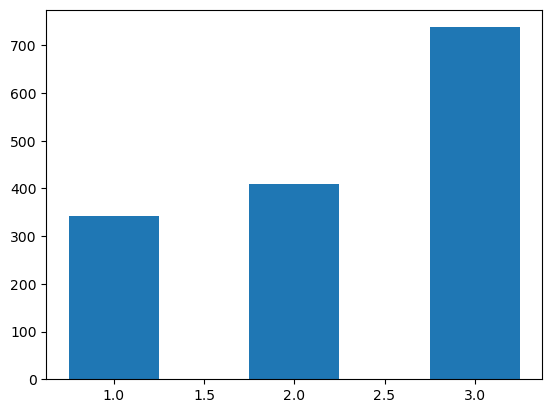

In [5]:
from collections import Counter
plt.bar(Counter(Y).keys(),Counter(Y).values(),width=0.5)
plt.show()

##### The above plot shows there is a high class imbalance and we need to resolve it.

In [6]:
#to reproduce results we use random state
np.random.RandomState(seed=42)
#splitting the data into train, test, validation 
from sklearn.model_selection import train_test_split
#as seen we need to give more weights to classes that have less weightage in the dataset
#label encoding 
from sklearn.preprocessing import OneHotEncoder
y=np.array(Y).reshape(-1,1)
encoder = OneHotEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y).toarray()
x_train_val,x_test,y_train_val,y_test=train_test_split(np.array(X),y_encoded,test_size=0.2,random_state=42)
x_train, x_val,y_train,y_val=train_test_split(x_train_val,y_train_val,test_size=0.1,random_state=42)
print("Shape of X Train data is : ",x_train.shape,"\n************")
print("Shape of Y Train data is : ",y_train.shape,"\n************")
print("Shape of X test data is : ",x_test.shape,"\n************")
print("Shape of Y test data is : ",y_test.shape,"\n************")
print("Shape of X Validation data is : ",x_val.shape,"\n************")
print("Shape of Y Validation data is : ", y_val.shape,"\n************")

Shape of X Train data is :  (1071, 228, 228, 3) 
************
Shape of Y Train data is :  (1071, 3) 
************
Shape of X test data is :  (298, 228, 228, 3) 
************
Shape of Y test data is :  (298, 3) 
************
Shape of X Validation data is :  (120, 228, 228, 3) 
************
Shape of Y Validation data is :  (120, 3) 
************


In [7]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [8]:
#normalize pixel values 
x_train = x_train/255.0
x_val = x_val/255.0
x_test = x_test/255.0
print("Pixel Values normalized")

Pixel Values normalized


In [10]:
#calculating the class weights and then we will use them to fit into our model
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(Y),y= Y)
# Convert the class weights to a dictionary to pass to the model
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.4512670565302144, 1: 1.2135289323553382, 2: 0.6725383920505872}

### Using Covolutional Neural Network for the Classification task

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [28]:
#define model
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',input_shape = (228,228,3)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

learning_rate = 0.001

model.compile(loss = "categorical_crossentropy",
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 226, 226, 16)      448       
                                                                 
 batch_normalization_8 (Batc  (None, 226, 226, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 batch_normalization_9 (Batc  (None, 224, 224, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                      

model=Sequential()
model.add

In [29]:
#creating checkpoints to prevent model from overfitting by monitoring the validation accuracy
model_path="D:/SEM6/ArtificialIntelligence/Project"
save_best = ModelCheckpoint (model_path, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')
early_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True)
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [25]:
y_train

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [30]:
tf.config.run_functions_eagerly(True)
history = model.fit( x_train, y_train, 
                    epochs = 50, batch_size = 100, 
                    callbacks=[save_best,early_callback,reduce_lr], verbose=1, 
                    validation_data = (x_val, y_val),class_weight=class_weights_dict)


C:\ProgramData\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 28.9589 - accuracy: 0.5406

INFO:tensorflow:Assets written to: D:/SEM6/ArtificialIntelligence\Project\assets


INFO:tensorflow:Assets written to: D:/SEM6/ArtificialIntelligence\Project\assets


11/11 [==============================] - 99s 9s/step - loss: 28.9589 - accuracy: 0.5406 - val_loss: 4.0237 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - 78s 7s/step - loss: 7.9987 - accuracy: 0.6732 - val_loss: 29.1124 - val_accuracy: 0.2250 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 3.7545 - accuracy: 0.7134

INFO:tensorflow:Assets written to: D:/SEM6/ArtificialIntelligence\Project\assets


INFO:tensorflow:Assets written to: D:/SEM6/ArtificialIntelligence\Project\assets


11/11 [==============================] - 97s 9s/step - loss: 3.7545 - accuracy: 0.7134 - val_loss: 12.5884 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 1.8049 - accuracy: 0.7311

INFO:tensorflow:Assets written to: D:/SEM6/ArtificialIntelligence\Project\assets


INFO:tensorflow:Assets written to: D:/SEM6/ArtificialIntelligence\Project\assets


11/11 [==============================] - 97s 9s/step - loss: 1.8049 - accuracy: 0.7311 - val_loss: 15.5551 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 5/50
11/11 [==============================] - ETA: 0s - loss: 1.0480 - accuracy: 0.7488

INFO:tensorflow:Assets written to: D:/SEM6/ArtificialIntelligence\Project\assets


INFO:tensorflow:Assets written to: D:/SEM6/ArtificialIntelligence\Project\assets


11/11 [==============================] - 98s 9s/step - loss: 1.0480 - accuracy: 0.7488 - val_loss: 11.4713 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/50
11/11 [==============================] - 78s 7s/step - loss: 0.7910 - accuracy: 0.7535 - val_loss: 7.4771 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 7/50
11/11 [==============================] - 46s 4s/step - loss: 0.6915 - accuracy: 0.7890 - val_loss: 5.7978 - val_accuracy: 0.3250 - lr: 1.0000e-04
Epoch 8/50
11/11 [==============================] - 40s 4s/step - loss: 0.5588 - accuracy: 0.8058 - val_loss: 4.9369 - val_accuracy: 0.3417 - lr: 1.0000e-04
Epoch 9/50
11/11 [==============================] - 39s 4s/step - loss: 0.5548 - accuracy: 0.7946 - val_loss: 4.8011 - val_accuracy: 0.3500 - lr: 1.0000e-04


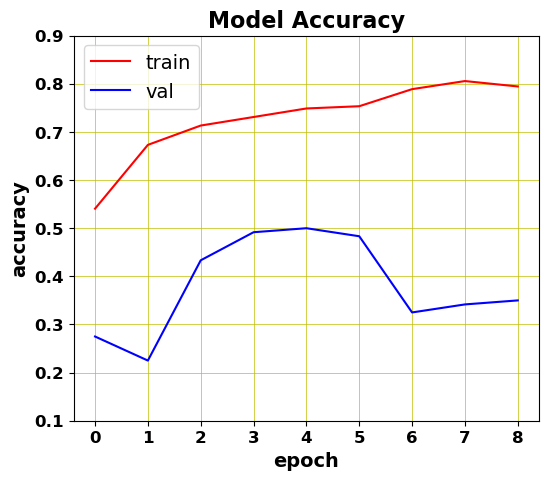

In [32]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.1, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

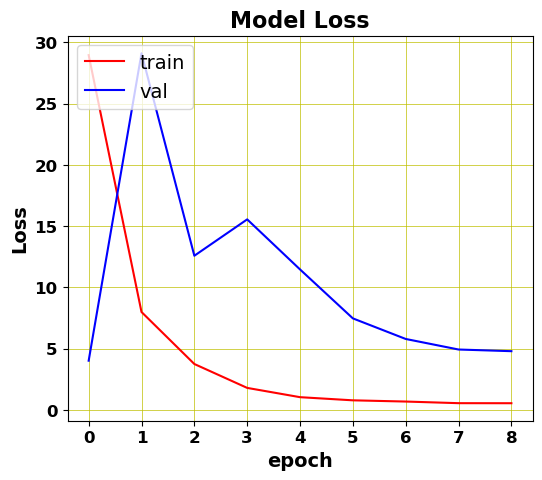

In [33]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss', weight='bold', fontsize=16)
plt.ylabel('Loss', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
# plt.ylim(0.1, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

### Evaluating the model

In [41]:
model_eval = tf.keras.models.load_model('D:/SEM6/ArtificialIntelligence/Project')
score = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

C:\ProgramData\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Accuracy over the test set: 
  25.5 %


### Feature Extraction

In [57]:
feature_extractor = keras.Model(
   inputs=model.inputs,
   outputs=model.get_layer(name="conv2d_11").output,
)

In [63]:
intermediate_output_test = feature_extractor(x_test)

In [64]:
test=intermediate_output_test.numpy()

In [67]:
#to remove memory error 


(300, 228, 228, 3)